In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install arabic-reshaper


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install python-bidi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim
import re
import math
import numpy as np
import pandas as pd
from nltk import ngrams
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
import csv
from collections import OrderedDict
import arabic_reshaper
from bidi.algorithm import get_display
import pickle

In [ ]:
#load all models
directory="/content/drive/My Drive/Research/"
models={}


models["cbow-wiki"]=gensim.models.Word2Vec.load('/content/drive/My Drive/Research/cbow-wiki/full_grams_cbow_300_wiki.mdl')
models["cbow-twitter"]=gensim.models.Word2Vec.load('/content/drive/My Drive/Research/cbow-twitter/full_grams_cbow_300_twitter.mdl')

In [ ]:
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!',"ة"]
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ',"ه"]
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text



In [ ]:
def get_count(token,vectors):
    if token in vectors:
        return vectors.vocab[token].count
    else:
        return 0



def get_vocab(token,vectors):
    if token in vectors:
      return vectors.vocab[token].count , vectors[token]
    else:
      return 0,np.zeros(300)

def cos_sim(emb1, emb2):
    return((emb1/np.linalg.norm(emb1)).dot(emb2/np.linalg.norm(emb2)))

#### **GENDER VECTOR**

In [ ]:
def gender_vector(pairs, vectors,n_components=1):
    N= len(pairs)

    mat= np.zeros((2*N,300),np.float64)
    for i in range(N):
        
        if(pairs[i][0] in vectors and pairs[i][1] in vectors):
            m_vector=vectors[pairs[i][0]]
            f_vector=vectors[pairs[i][1]]
        elif(clean_str(pairs[i][0]) in vectors and clean_str(pairs[i][1]) in vectors):
            m_vector=vectors[clean_str(pairs[i][0])]
            f_vector=vectors[clean_str(pairs[i][1])]
            
        elif(clean_str(pairs[i][0]) in vectors and pairs[i][1] in vectors):
            m_vector=vectors[clean_str(pairs[i][0])]
            f_vector=vectors[pairs[i][1]]
            
        elif(pairs[i][0] in vectors and clean_str(pairs[i][1]) in vectors):
            m_vector=vectors[pairs[i][0]]
            f_vector=vectors[clean_str(pairs[i][1])]
            
        center=(f_vector+m_vector)/2
        mat[2*i]=f_vector-center
        mat[2*i+1]=m_vector-center

      


    pca = PCA(n_components = n_components)
    mat2=pca.fit_transform(mat.transpose())
#     plt.bar(range(n_components), pca.explained_variance_ratio_)
    return  mat2.flatten()
    


#**Bias Test**

In [ ]:
def group_bias(g,male_words,female_words,vectors):
    N=len(male_words)
    total=0.0
    for i in range(len(male_words)):
        if(male_words[i] in vectors and female_words[i] in vectors):
            b=word_bias(g,male_words[i],female_words[i],vectors)
        elif(clean_str(male_words[i]) in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,clean_str(male_words[i]),clean_str(female_words[i]),vectors)
        elif(clean_str(male_words[i]) in vectors and female_words[i] in vectors):
            b=word_bias(g,clean_str(male_words[i]),female_words[i],vectors)
        elif(male_words[i] in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,male_words[i],clean_str(female_words[i]),vectors)
        else:
            continue
        if not math.isnan(b):
            total=total+b
    total=total/N
    return total

In [ ]:
def group_bias_details(g,male_words,female_words,vectors):
    N=len(male_words)
    total=0.0
    for i in range(len(male_words)):
        if(male_words[i] in vectors and female_words[i] in vectors):
            b=word_bias_details(g,male_words[i],female_words[i],vectors)
        elif(clean_str(male_words[i]) in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias_details(g,clean_str(male_words[i]),clean_str(female_words[i]),vectors)
        elif(clean_str(male_words[i]) in vectors and female_words[i] in vectors):
            b=word_bias_details(g,clean_str(male_words[i]),female_words[i],vectors)
        elif(male_words[i] in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias_details(g,male_words[i],clean_str(female_words[i]),vectors)
        else:
            continue
        if not math.isnan(b):
            total=total+b
    total=total/N
    return total

In [ ]:
def getBias (male_words,female_words,vectors):
    
    biases=[]
    b=0
    for i in range(len(male_words)):
        if(male_words[i] in vectors and female_words[i] in vectors):
            b=word_bias(g,male_words[i],female_words[i],vectors)
        elif(clean_str(male_words[i]) in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,clean_str(male_words[i]),clean_str(female_words[i]),vectors)
        elif(clean_str(male_words[i]) in vectors and female_words[i] in vectors):
            b=word_bias(g,clean_str(male_words[i]),female_words[i],vectors)
        elif(male_words[i] in vectors and clean_str(female_words[i]) in vectors):
            b=word_bias(g,male_words[i],clean_str(female_words[i]),vectors)
        biases.append(b)
    return biases
    

In [ ]:
def word_bias(g,male,female,vectors):
    m=get_vocab(male,vectors)
    f=get_vocab(female,vectors)
    average=(m[0]*cos_sim(m[1],g) + f[0]*cos_sim(f[1],g)) / (m[0]+f[0])
#     print(average," : ",male,"-",female)
#     average=(cos_sim(m[1],g) + cos_sim(f[1],g)) / 2
    return average

In [ ]:
def word_bias_details(g,male,female,vectors):
    m=get_vocab(male,vectors)
    f=get_vocab(female,vectors)
    average=(m[0]*cos_sim(m[1],g) + f[0]*cos_sim(f[1],g)) / (m[0]+f[0])
    print(average," : ",male,"-",female)
    # average=(cos_sim(m[1],g) + cos_sim(f[1],g)) / 2
    return average

In [ ]:
#Horizontal
def plotBar(row,col,title,xLabel,yLabel,location):
    colors=['b','m','y','r']
    bias=['CorrectM',"CorrectF","Relatively Correct","Incorrect"]
    new_col = [ ]

    for item in col:
        new_col.append(get_display(arabic_reshaper.reshape(item)))
    # creating the bar plot
    y=np.arange(len(col))   
    x=row  

    plt.rcdefaults()
    fig, ax = plt.subplots()
    fig = plt.figure()
    barlist=ax.barh(y, x, align='center')
    for b in range(len(barlist)):
      if x[b] < 0:
        barlist[b].set_color(colors[0])
      elif x[b]==0:
        barlist[b].set_color(colors[2])
      else:
        barlist[b].set_color(colors[3])
    ax.set_yticks(y)
    ax.set_yticklabels(new_col)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_ylabel(yLabel)
    ax.set_xlabel(xLabel)
    ma=max(x)
    mi=abs(min(x))
    lim=ma
    if ma < mi:
        lim=mi
    ax.set_xlim([-lim*1.2, lim*1.2])
    ax.set_title(title)
    ax.grid(color='grey', linestyle='dotted', linewidth=0.3)
    
    # fig.show()
    fig.savefig(location)


# **Generating Names**


In [ ]:
i=['صهيوني', 'إسرائيلي', 'الإسرائيليين', 'يهود', 'إسرائيل', 'أبيب', 'اليهود', 'شارون']
i.sort()

p=['المسلمين', 'الفلسطينيون', 'فلسطينيون', 'حماس', 'فلسطين', 'فلسطيني', 'التحرير', 'الفلسطينية']
p.sort()


nouns=list(zip(p, i))

# Categories


In [ ]:
categories={}
#Occupation

Occupation=['تفتيش', 'إخلاء', 'مستوطنة', 'المستوطنين', 'مستوطن', 'احتل', 'هدم', 'احتلال', 'انفصال', 'الهدم', 'المستوطنات', 'عزل', 'سجناء', 'انسحاب', 'صاروخ', 'الهجمات', 'الصواريخ', 'قصف', 'انفجار', 'غارة']
Occupation.sort()
categories["Occupation"]={"male":Occupation,"female":Occupation}


#Resistance

Resistance =['معاناة', 'كفاح', 'نضال', 'صراع', 'تحمل', 'الصمود', 'المقاومة', 'صمود', 'التأقلم', 'المواجهة', 'تأقلم', 'مواجهة', 'مقاومة']
Resistance.sort()
categories["Resistance "]={"male":Resistance ,"female":Resistance}



#Peace
Peace=["مسالم","سلام","السلمي","سلمي","امن","أمان","هادئ","هدوء","سكون","سلمية"]
Peace.sort()
categories["Peace"]={"male":Peace,"female":Peace}


#Terrorism & Violence
Violence=['الضربات', 'هجوم', 'أسلحة', 'اعتداء', 'ضربة', 'خرق', 'الجريمة', 'عنف', 'اضطهاد', 'مطرود', 'أذى', 'جريمة', 'بطش', 'قسوة']
Violence.sort()
Terrorism=['مذبحة', 'جناية', 'جريمة', 'القتل', 'الإعدام', 'إرهابيين', 'الإرهاب', 'الرصاص', 'إراقة', 'إرهاب', 'إرهابي', 'الذبح', 'محاكمة']
Terrorism.sort()
vt=Violence+Terrorism
categories["V&T"]={"male":vt,"female":vt}

#Validation
len(categories)

for c in categories:
    if len(categories[c]["male"]) != len(categories[c]["female"]): 
                                               print(c)

# Running Bias Test

In [ ]:
df = pd.DataFrame(columns = ['Model']+list(categories.keys()))
for n in models:
            
    vectors=models[n].wv
    row=[]
    row.append(n)
    
    g=gender_vector(nouns,vectors)
    for c in categories:
        bias=group_bias_details(g,categories[c]["male"],categories[c]["female"],vectors)
        row.append(bias)
#                 print(n,m,c,bias)
        print("-----------------------------------")
    df.loc[len(df.index)]=row
        


0.09600879982594576  :  اخلاء - اخلاء
0.12442877474347894  :  احتل - احتل
0.2197241775857331  :  احتلال - احتلال
-0.08696093613036189  :  الصواريخ - الصواريخ
0.31932659777315336  :  المستوطنات - المستوطنات
0.4680790514662596  :  المستوطنين - المستوطنين
0.08291159490674543  :  الهجمات - الهجمات
0.07205415382567124  :  الهدم - الهدم
-0.002453984579851829  :  انسحاب - انسحاب
-0.15748812119654837  :  انفجار - انفجار
-0.01626297366165419  :  انفصال - انفصال
-0.1100209290330939  :  تفتيش - تفتيش
0.19400095560456887  :  سجناء - سجناء
-0.11682472581770321  :  صاروخ - صاروخ
-0.02533824541860174  :  عزل - عزل
0.06715701087624522  :  غاره - غاره
-0.06109216901775694  :  قصف - قصف
0.13902216341503346  :  مستوطن - مستوطن
0.22747839621612567  :  مستوطنه - مستوطنه
0.2027535432297443  :  هدم - هدم
-----------------------------------
-0.005708021812281299  :  التاقلم - التاقلم
0.002527688800575979  :  الصمود - الصمود
-0.04563590264700653  :  المقاومه - المقاومه
0.01685184965639914  :  المواجهه - المواج

In [ ]:
display(df)

,Model,Occupation,Resistance,Peace,V&T
0,cbow-wiki,0.081825,-0.012989,-0.007267,0.056983
1,cbow-twitter,0.082529,-0.016809,0.064579,0.174417


In [ ]:
directory='/content/drive/My Drive/Research/'

In [ ]:
with open(directory+'/cbow.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Results

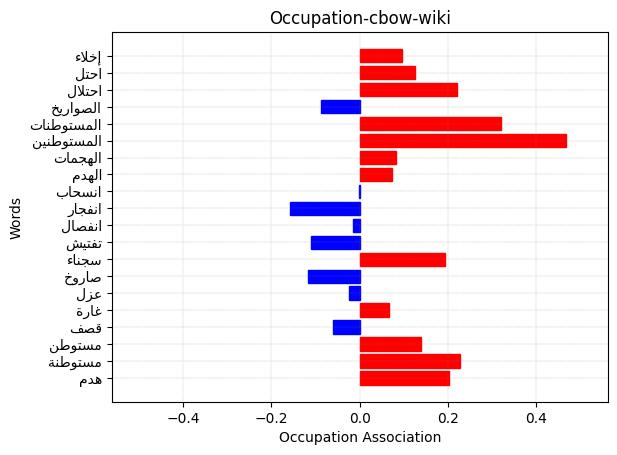

<Figure size 640x480 with 0 Axes>

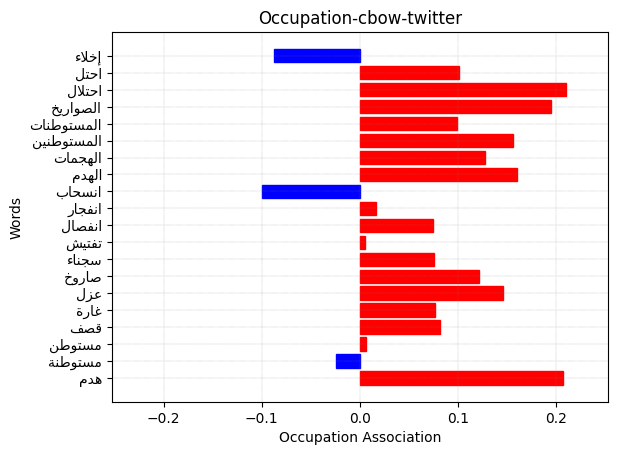

<Figure size 640x480 with 0 Axes>

In [ ]:
#By Category
for m in models:

        vectors=models[m].wv
        g=gender_vector(nouns,vectors)
        for c in categories:
          if c == 'Occupation':
            location="politics/byCategory/"+c+'-'+m+'.png'
            plotBar(getBias(categories[c]['male'],categories[c]['male'],vectors),categories[c]['male'],c+'-'+m,c+" Association","Words",directory+location)
           


           


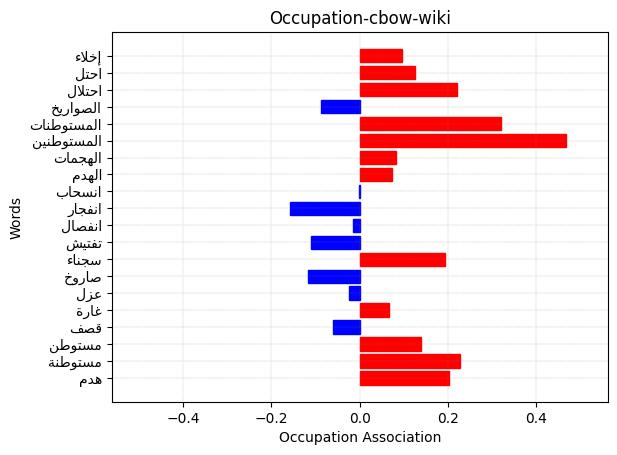

<Figure size 640x480 with 0 Axes>

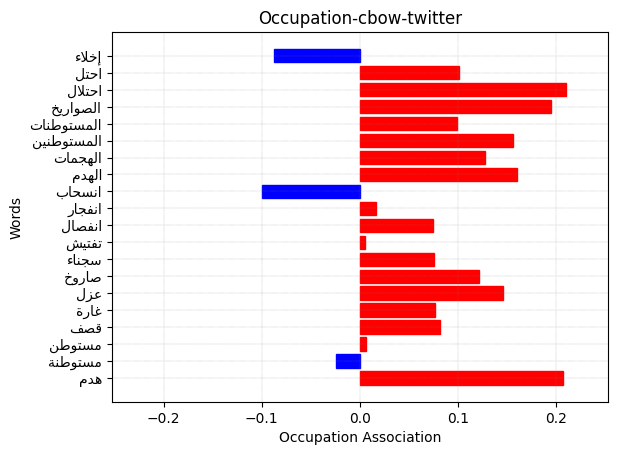

<Figure size 640x480 with 0 Axes>

In [ ]:
##By Model

for m in models:

    vectors=models[m].wv
    g=gender_vector(nouns,vectors)
    for c in categories:
      if c == 'Occupation':
        location="politics/byModel/"+m+'-'+c+'.png'
        plotBar(getBias(categories[c]['male'],categories[c]['male'],vectors),categories[c]['male'],c+'-'+m,c+" Association","Words",directory+location)

#**RUN THE CODE AGAIN WITH THE OTHER ALGORITHM**

######**Load dataframes**

In [ ]:
with open(directory+'/cbow.pickle', 'rb') as handle:
    cbow = pickle.load(handle)


In [ ]:
df=pd.concat([cbow],ignore_index=True)
display(df)

,Model,Occupation,Resistance,Peace,V&T
0,cbow-wiki,0.081825,-0.012989,-0.007267,0.056983
1,cbow-twitter,0.082529,-0.016809,0.064579,0.174417


In [ ]:
pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 26.8 MB/s 


In [ ]:
writer = pd.ExcelWriter(directory+"/politics/political_results.xlsx", engine='xlsxwriter')

df.to_excel(writer, sheet_name="models", startrow=0, header=True, index=False)
writer.save()

##Read Excel

In [ ]:
dfs = pd.read_excel(directory+"/politics/political_results.xlsx", sheet_name='models')


In [ ]:
dfs

,Model,Occupation,Resistance,Peace,V&T
0,cbow-wiki,0.081825,-0.012989,-0.007267,0.056983
1,cbow-twitter,0.082529,-0.016809,0.064579,0.174417


In [ ]:
cats=list(dfs.columns)[1:]

newcats=cats

print(newcats)

['Occupation', 'Resistance ', 'Peace', 'V&T']


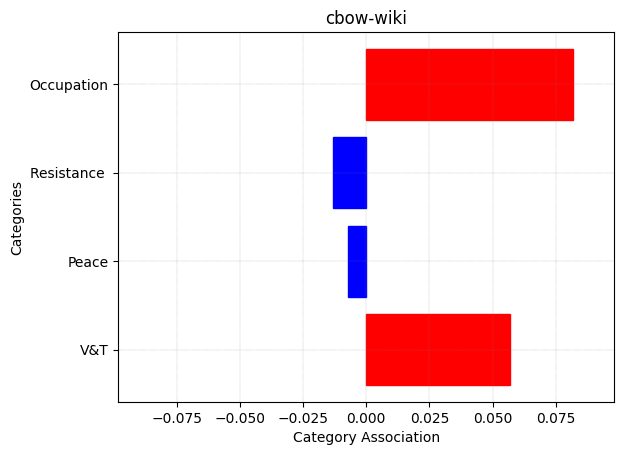

<Figure size 640x480 with 0 Axes>

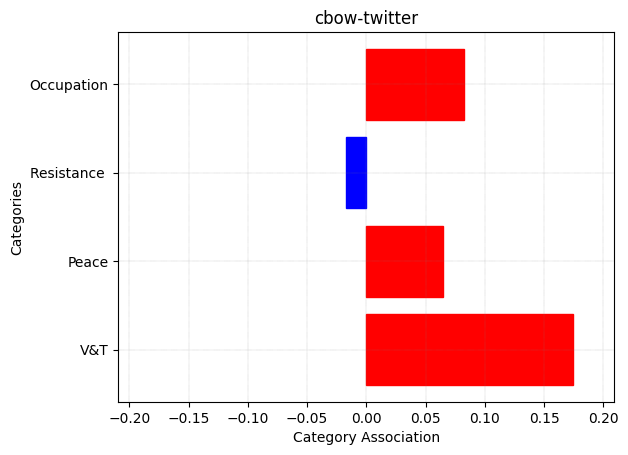

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(dfs)):
    row=list(dfs.iloc[i])
    plotBar(row[1:],cats,row[0],"Category Association","Categories",directory+'politics/'+row[0]+'.png')
